In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(1) # reproducible

TIME_STEP = 10
INPUT_SIZE = 1
LR = 0.02

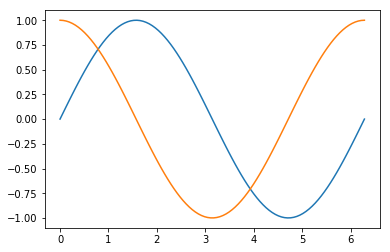

In [3]:
step = np.linspace(0, 2*np.pi, 100, dtype=np.float)
x_np = np.sin(step)
y_np = np.cos(step)

plt.plot(step, x_np)
plt.plot(step, y_np)

In [4]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        self.rnn = nn.RNN(input_size=INPUT_SIZE,
                          hidden_size=32,
                          num_layers=1,
                          batch_first=True,
                         )
        self.out = nn.Linear(in_features=32,
                             out_features=1
                            )
        
    def forward(self, x, h_state):
        # x: (batch_size, time_step, input_size)
        # h_state: (num_layers, batch_size, hidden_size)
        # r_out: (batch_size, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)
        
#         # 1. 將r_out每一個time step的結果都放入下一層linear計算後再合併
#         outs = []
#         for t in range(r_out.size(1)): # calc each time step
#             outs.append(self.out(r_out[:, t, :]))
#         return torch.stack(outs, dim=1), h_state

        # 2. 更改資料維度後用矩陣算法
        r_out = r_out.view(-1, 32)
        outs = self.out(r_out)
        outs = outs.view(-1, TIME_STEP, 1)
        return outs, h_state        

In [5]:
rnn = RNN()
rnn.cuda()
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


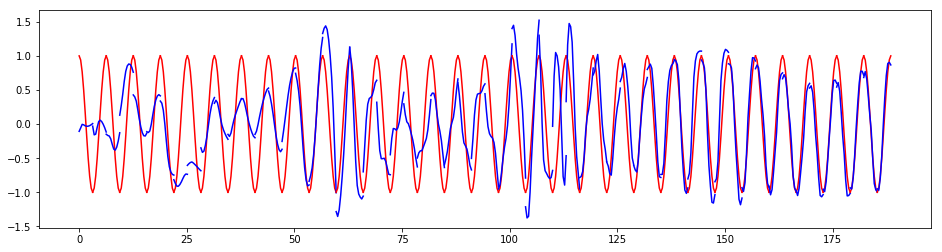

In [6]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = nn.MSELoss()

h_state = None # init h_state，會生成一個全0的hidden state

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 4)

for step in range(60):
    
    # 擷取一小段距離
    start, end = step * np.pi, (step+1) * np.pi
    # print(start, end)
    
    # 在這段距離中擷取time step個數據點
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    # print(steps)
    x_np = np.sin(steps)
    y_np = np.cos(steps)
    # plt.plot(steps, x_np, 'r')
    # plt.plot(steps, y_np, 'b')
    
    x = torch.from_numpy(x_np).view(1, -1, 1) # (batch, time step, input size)
    y = torch.from_numpy(y_np).view(1, -1, 1) # (batch, time step, input size)
    # 另一種寫法
    # x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis]) # 增加維度，變成(batch, time step, input size)，也可以使用np.expand()
    # y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])
    
    x = x.cuda()
    y = y.cuda()
    
    prediction, h_state = rnn(x, h_state)
    # h_state是動態圖的一部分，torch在backward時為了節省內存會釋放動態圖，於是h_state就不見了，下一次計算動態圖就會出事情
    # 為了解決這個問題，只把h_state的值取出來
    h_state = h_state.data
    loss = loss_func(prediction, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # plotting
    plt.plot(steps, y_np.flatten(), 'r-')
    plt.plot(steps, prediction.data.cpu().numpy().flatten(), 'b-')